# Second time series

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns

## Sources
- <a href="https://en.wikipedia.org/wiki/Skewness">skewness</a>
- <a href="https://www.investopedia.com/terms/k/kurtosis.asp">kurtosis</a>
- <a href="https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test">Jarque-Bera</a>

In [3]:
def calculate_metrics_sample(y):
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return y_dict

In [4]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(10,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample)
    plt.grid(True)
    plt.show()
    
    plot_acf(y, lags=lags);
    plot_pacf(y, lags=lags);

In [5]:
def ARMA(p, q, y_, res_, b=None):
    
    df_temp = pd.DataFrame(list(y_), columns=['Value'])
    
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    df_train_2 = df_temp.dropna()
#     df_train_2 = df_temp.fillna(0)
    X_train_ar = df_train_2.iloc[:,1:].values.reshape(-1,p)
    y_train_ar = df_train_2.iloc[:,0].values.reshape(-1,1)
    
    lr = LinearRegression()
    lr.fit(X_train_ar,y_train_ar)

    theta_ar  = lr.coef_.T
    intercept_ar = lr.intercept_

    df_train_2['Predicted_Values'] = X_train_ar.dot(theta_ar) + intercept_ar
    
    #----------------
    res = pd.DataFrame(list(res_), columns=['Residuals'])
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    res_train_2 = res.dropna()
#     res_train_2 = res.fillna(0)
    X_train_ma = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train_ma = res_train_2.iloc[:,0].values.reshape(-1,1)
    
    if b is None:
        lr = LinearRegression()
        lr.fit(X_train_ma,y_train_ma)

        theta_ma  = lr.coef_.T
        intercept_ma = lr.intercept_
    else:
        theta_ma = np.array(b)
        intercept_ma = 0

    res_train_2['Predicted_Values'] = X_train_ma.dot(theta_ma) + intercept_ma

    prediction = pd.DataFrame(res_train_2['Predicted_Values'] + df_train_2['Predicted_Values'],columns=['Predicted_Values'])
#     pred = list(prediction['Predicted_Values'])
    prediction = prediction.dropna()
    pred = [x for x in y_[:max(p,q)]] + list(prediction.Predicted_Values)

    return pred,theta_ar, theta_ma, intercept_ar + intercept_ma

### Calculate metrics

- <a href="https://www.investopedia.com/terms/r/r-squared.asp">R squared</a>
- <a href="https://en.wikipedia.org/wiki/Residual_sum_of_squares">sum_squared_resid</a>
- <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">AIC</a>
- <a href="https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic">Duarbin-Watson</a>

In [6]:
def claculate_metrics_model_reg(y, y_pred, model_params):
    y , y_pred = np.array(y), np.array(y_pred)
    
    model_arma_metric = {}
    model_arma_metric['r_squared'] = (np.var(y_pred)/np.var(y))**2# r2_score(y, y_pred)
    model_arma_metric['sum_squared_resid'] = sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid']) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T,
                        columns=['r_squared', 'sum_squared_resid', 'aic','durbin_watson'])

In [7]:
def claculate_metrics_model(y, y_pred, p, q, weight, window, params_ar, params_ma, intercept):
    
    y , y_pred = np.array(y), np.array(y_pred)
    
#     print(f'pred:\t{y_pred}')
#     print(f'y:\t{y}')
    model_params = p + q
    model_arma_metric = {}
    model_arma_metric['name'] = f'ARMA({p,q}) {weight}:{window}'
    model_arma_metric['r_squared'] = (np.var(y_pred)/np.var(y))**2# r2_score(y, y_pred)
    model_arma_metric['sum_squared_resid'] = np.sum((y - y_pred)**2)
    model_arma_metric['aic'] = len(y) * np.log(model_arma_metric['sum_squared_resid'] / len(y)) + 2*model_params
    model_arma_metric['durbin_watson'] = durbin_watson(y - y_pred)
    model_arma_metric['params_ar'] = params_ar
    model_arma_metric['params_ma'] = params_ma
    model_arma_metric['params_intercept'] = intercept
    
    return pd.DataFrame(np.array([[metr] for metr in model_arma_metric.values()]).T, 
                        columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])

In [8]:
def weight(res, weight, window):
    
    res_copy = res.copy()
    if weight=='simple':
        wma = res_copy.rolling(window=window).mean()
        
        
    elif weight== 'exponential':
        wma = res_copy.ewm(span=window).mean()
    
    else:
        pass
    
    wma[:window] = res_copy[:window]
    return wma

In [9]:
def show_prediction(y, y_pred, name):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y)
    plt.plot(y_pred)

## ARMA

In [10]:
file1 = open('ATS_lab_03_new/Data/rts2.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])
y = pd.Series(y)
(len(y))

178

## Зобразимо описові характеристики ряду

In [11]:
lags=40
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 178,
 'mode': 1441.95,
 'mean': 2383.844325842696,
 'median': 2483.955,
 'variation': 84278.55461564464,
 'skewness': -1.7155134717692684,
 'kurtosis': 2.0883341673064533,
 'jarque-bera': 115.40614985041333,
 'probability': 0.0}

In [12]:
y.describe()

count     178.000000
mean     2383.844326
std       290.307690
min      1441.950000
25%      2396.500000
50%      2483.955000
75%      2576.405000
max      2670.610000
dtype: float64

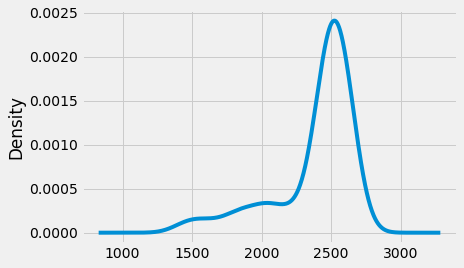

In [13]:
y.plot(kind='kde')

In [14]:
# y = np.log(y)

In [15]:
calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 178,
 'mode': 1441.95,
 'mean': 2383.844325842696,
 'median': 2483.955,
 'variation': 84278.55461564464,
 'skewness': -1.7155134717692684,
 'kurtosis': 2.0883341673064533,
 'jarque-bera': 115.40614985041333,
 'probability': 0.0}

## продиференціюємо ряд, оскільки метод не працює з нестаціонарним рядом

In [16]:
diff_y = pd.Series(y).diff(periods=1).dropna()
test = sm.tsa.adfuller(diff_y)
y = np.array(diff_y).reshape(1,-1)[0]
y = pd.Series(y)

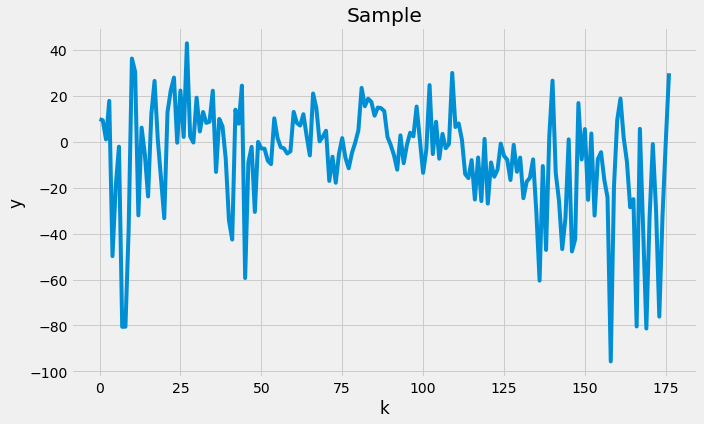

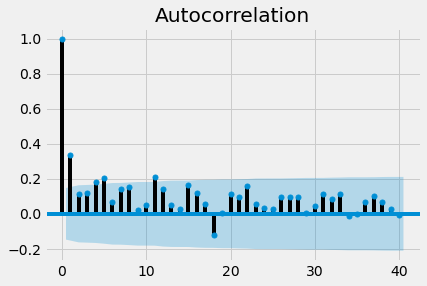

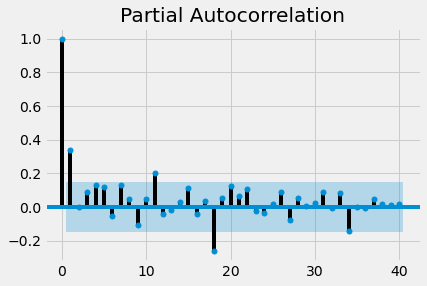

In [17]:
calculate_metrics_sample(y)
show_plots(y)

Із значення автокореляції обираємо p = 11

- [How to choose parameters for ARMA model](https://arauto.readthedocs.io/en/latest/how_to_choose_terms.html)

## ARMA is built by residual 

In [18]:
model = ARIMA(y, order=(11,0,0))
model_fit = model.fit()

print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  177
Model:                    ARMA(11, 0)   Log Likelihood                -786.256
Method:                       css-mle   S.D. of innovations             20.454
Date:                Thu, 29 Oct 2020   AIC                           1598.511
Time:                        13:45:49   BIC                           1639.801
Sample:                             0   HQIC                          1615.257
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.5694      4.808     -1.574      0.115     -16.993       1.855
ar.L1.y        0.3061      0.074      4.132      0.000       0.161       0.451
ar.L2.y        0.0178      0.078      0.228      0.8

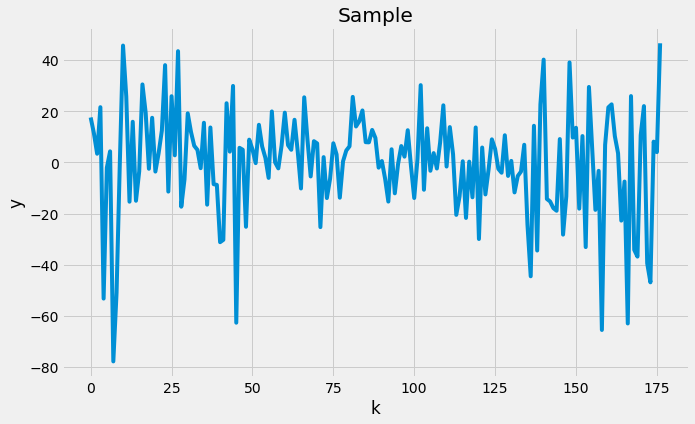

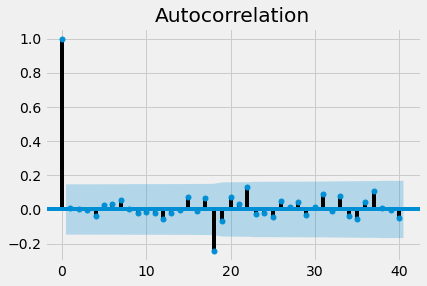

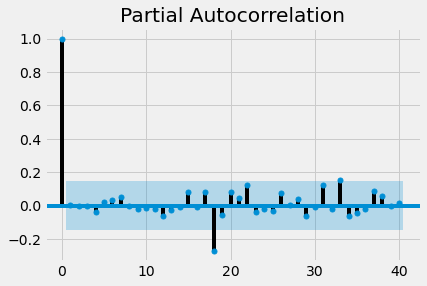

In [19]:
res =  model_fit.resid
show_plots(res)

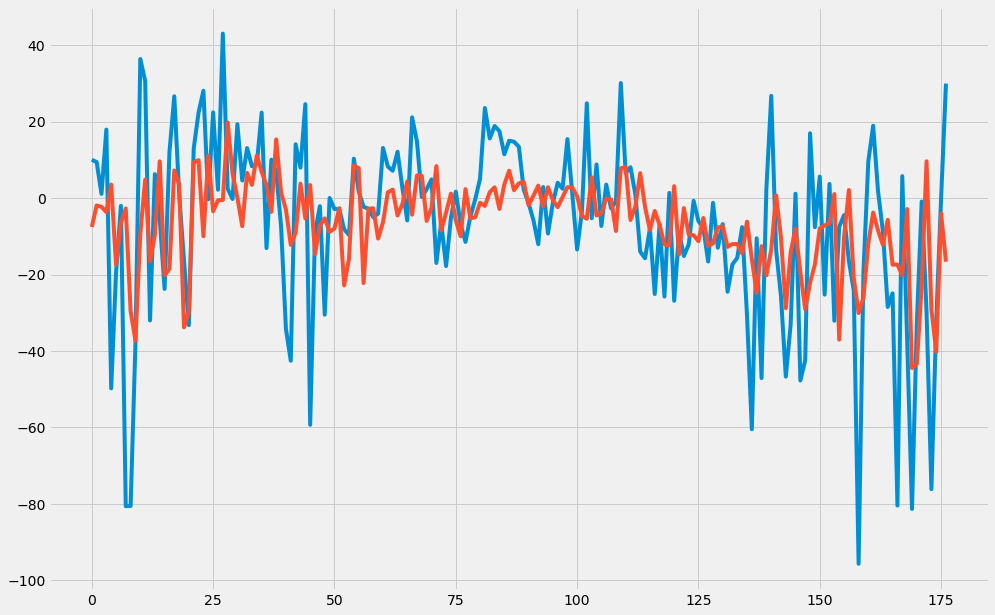

In [20]:
plt.figure(figsize= (15,10))

plt.plot(y)
plt.plot(np.array(model_fit.predict()))

In [21]:
models_metrics = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model = []

p, q = 11,18

mv5_simple = weight(res, weight='simple',window=5)
mv10_simple = weight(res, weight='simple',window=10)
mv5_epx = weight(res, weight='exponential',window=5)
mv10_epx = weight(res, weight='exponential',window=10)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple, mv5_simple)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple, mv10_simple)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_epx, mv5_epx)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)

pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_epx, mv10_epx)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics = models_metrics.append(metrics, ignore_index=True)
predictions_model.append(pred)


## зообразимо отримані метрики готових моделей

In [22]:
models_metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 18)) simple:5",0.100719,65313,1104.21,1.91399,"[[0.11876229814926621], [-0.11183228645289636]...","[[0.8716380337500879], [0.10172977898151951], ...",[-2.3807996444826407]
1,"ARMA((11, 18)) simple:10",0.0718824,71618.1,1120.52,1.89818,"[[0.20354178427586914], [-0.047668343196084526...","[[0.8994922387271542], [0.08917918323982957], ...",[-3.0780578611523755]
2,"ARMA((11, 18)) exponential:5",0.0740454,63686.8,1099.75,1.96523,"[[0.11289117250849424], [-0.052366968155805674...","[[0.5884166742635326], [0.09653438502140432], ...",[-1.656322428192446]
3,"ARMA((11, 18)) exponential:10",0.0630733,70825.3,1118.55,1.90036,"[[0.15369320532157904], [-0.07967613148711446]...","[[0.748570871018412], [0.10160950321108617], [...",[-2.590426647026015]


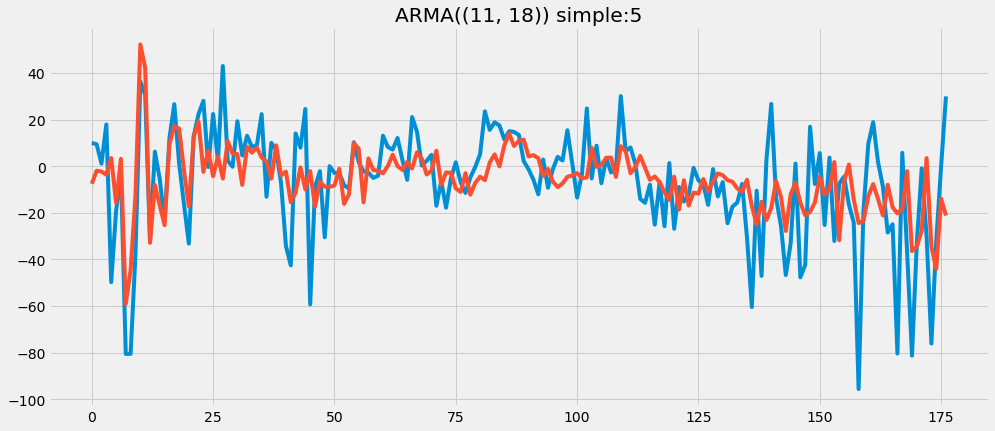

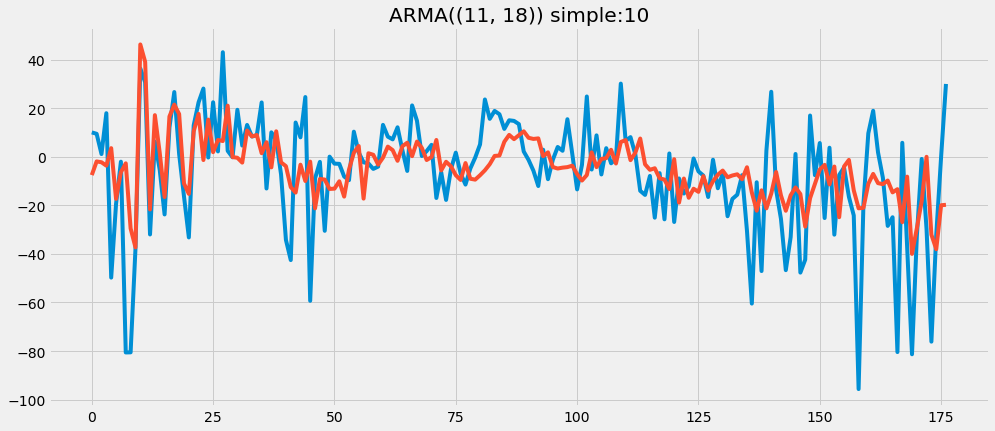

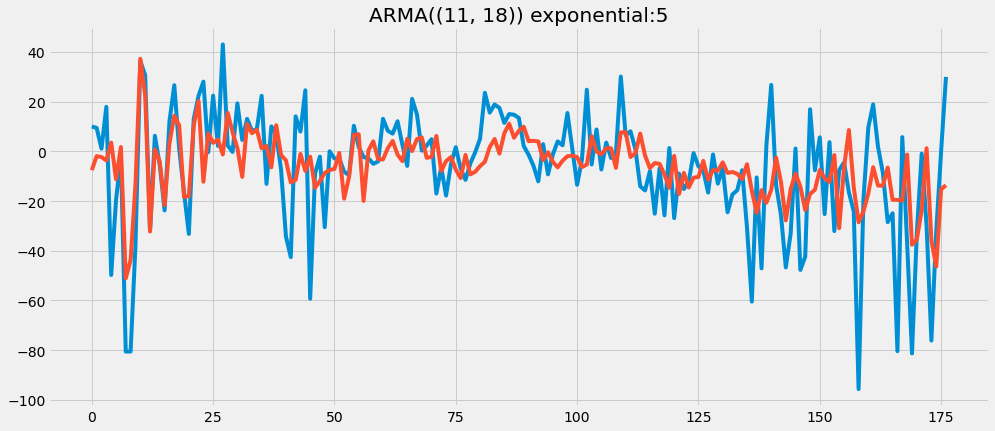

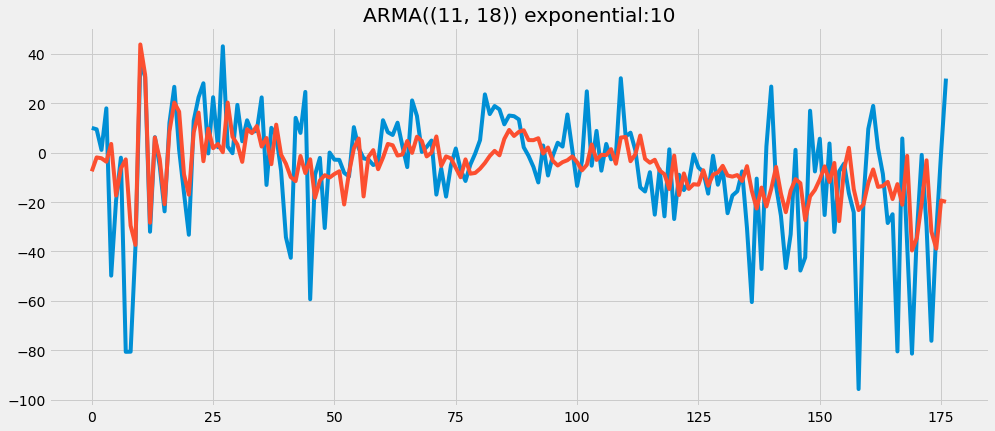

In [23]:
for name, y_pred in zip(models_metrics.name, predictions_model):
    show_prediction(y, y_pred, name)

In [24]:
models_metrics.to_excel('result/table_1_2.xls')

## 2. Побудова ARMA(p,q) коли КС будується по вихідному сигналу у 

## Власні коефіцієнти

In [25]:
def know_b(y, mv,q, window):
    a = 2/(window+1)
    s = sum([(1-a)**i for i in range(1, q+1)])
    b = [(1/s)*((1-a)**i) for i in range(1, q+1)]
    y_new = []
    for i in range(len(y)):
        s = y[i]-mv[i]
        
        for j in range(q):
            if( i - j -1 > -1):
                s += -mv[i-j-1]*b[j]
        y_new.append(s)
        
    return y_new, b

In [26]:
# diff_y = pd.Series(y).diff(periods=1).dropna()
# test = sm.tsa.adfuller(diff_y)
# y = np.array(diff_y).reshape(1,-1)[0]

# y = np.log(y)

calculate_metrics_sample(y)

{'series': 'Y',
 'observations': 177,
 'mode': -32.08999999999992,
 'mean': -6.555423728813558,
 'median': -2.3099999999999454,
 'variation': 548.5985783705695,
 'skewness': -1.2254104517886915,
 'kurtosis': 2.3372462418835633,
 'jarque-bera': 80.48860627902138,
 'probability': 0.0}

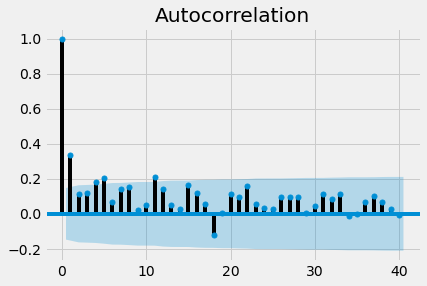

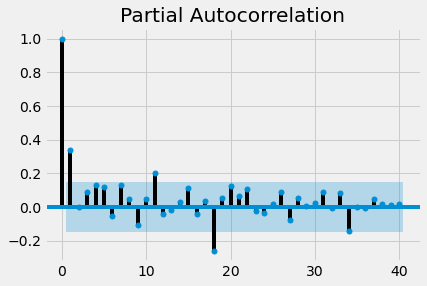

In [27]:
plot_acf(y, lags=lags);
plot_pacf(y, lags=lags);

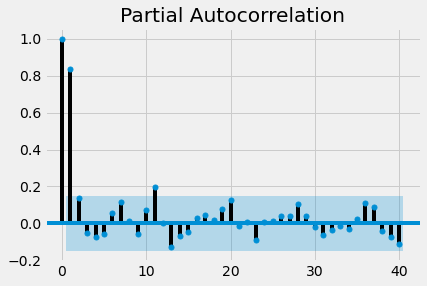

In [28]:
models_metrics_1 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_1 = []
window = 5
mv5_simple = weight(pd.DataFrame(y), weight='simple',window=window)
plot_pacf(pd.Series(mv5_simple[0]), lags=lags);

In [29]:
p,q=11, 11
y_new2, b2 = know_b(y, mv5_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_simple[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 11)) simple:5",0.126977,92262.5,1151.36,1.7215,"[[0.4398361478727209], [0.061226937541329164],...","[0.3372320801375222, 0.22482138675834815, 0.14...",[1.914367096125999]


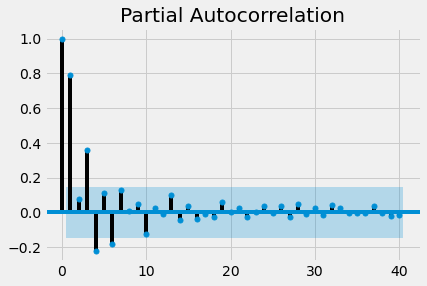

In [30]:
window = 10
mv10_simple = weight(pd.DataFrame(y), weight='simple',window=window)
plot_pacf(mv10_simple, lags=lags);

In [31]:
q=6
y_new2, b2 = know_b(y, mv10_simple[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_simple[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 6)) simple:10",0.114924,110481,1173.25,1.48309,"[[0.3924253837850733], [0.07242064485039773], ...","[0.25973454181853367, 0.21251007966970936, 0.1...",[1.9621420753478027]


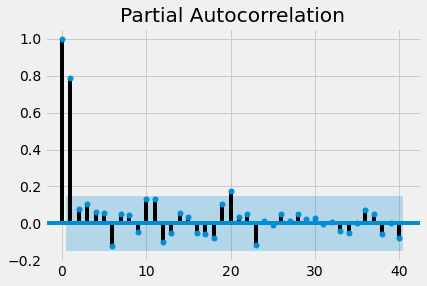

In [32]:
window = 5
mv5_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv5_exp, lags=lags);

In [33]:
q=20
y_new2, b2 = know_b(y, mv5_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv5_exp[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 20)) exponential:5",0.107249,92512.3,1169.83,1.42585,"[[0.3514474197287487], [0.07139159389587134], ...","[0.333433606374918, 0.22228907091661199, 0.148...",[1.5016556222867177]


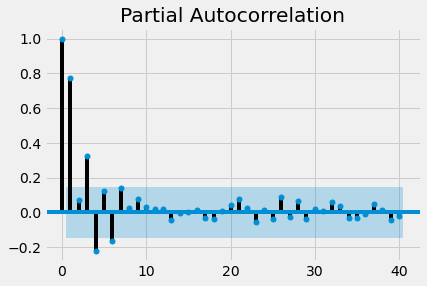

In [34]:
window = 10
mv10_exp = weight(pd.DataFrame(y), weight='exponential',window=window)
plot_pacf(mv10_exp, lags=lags);

In [35]:
q=6
y_new2, b2 = know_b(y, mv10_exp[0], q, window)
pred, params_ar, params_ma, intercept = ARMA(p, q, y_new2, mv10_exp[0], b2)
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=window, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_1 = models_metrics_1.append(metrics, ignore_index=True)
predictions_model_1.append(pred)
metrics

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 6)) exponential:10",0.0970561,107619,1168.61,1.46959,"[[0.3524856149208306], [0.0540831551936399], [...","[0.25973454181853367, 0.21251007966970936, 0.1...",[1.7866611721654069]


## зообразимо отримані метрики готових моделей

In [36]:
models_metrics_1

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 11)) simple:5",0.126977,92262.5,1151.36,1.7215,"[[0.4398361478727209], [0.061226937541329164],...","[0.3372320801375222, 0.22482138675834815, 0.14...",[1.914367096125999]
1,"ARMA((11, 6)) simple:10",0.114924,110481,1173.25,1.48309,"[[0.3924253837850733], [0.07242064485039773], ...","[0.25973454181853367, 0.21251007966970936, 0.1...",[1.9621420753478027]
2,"ARMA((11, 20)) exponential:5",0.107249,92512.3,1169.83,1.42585,"[[0.3514474197287487], [0.07139159389587134], ...","[0.333433606374918, 0.22228907091661199, 0.148...",[1.5016556222867177]
3,"ARMA((11, 6)) exponential:10",0.0970561,107619,1168.61,1.46959,"[[0.3524856149208306], [0.0540831551936399], [...","[0.25973454181853367, 0.21251007966970936, 0.1...",[1.7866611721654069]


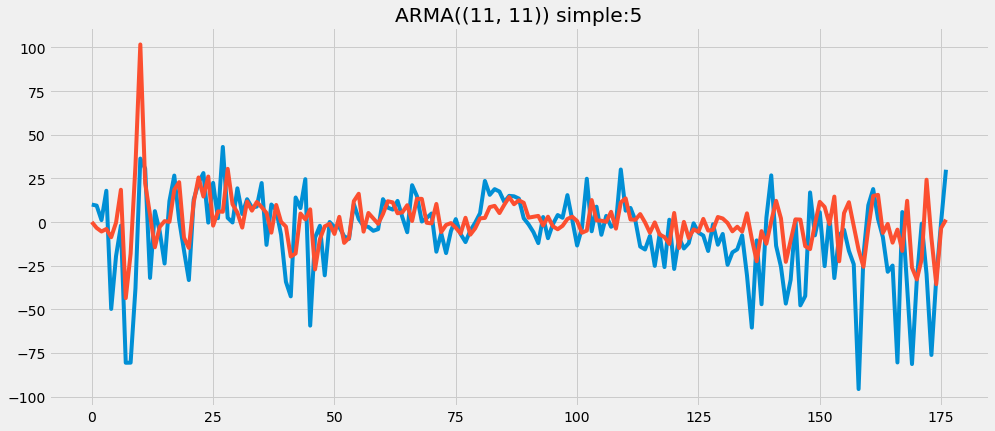

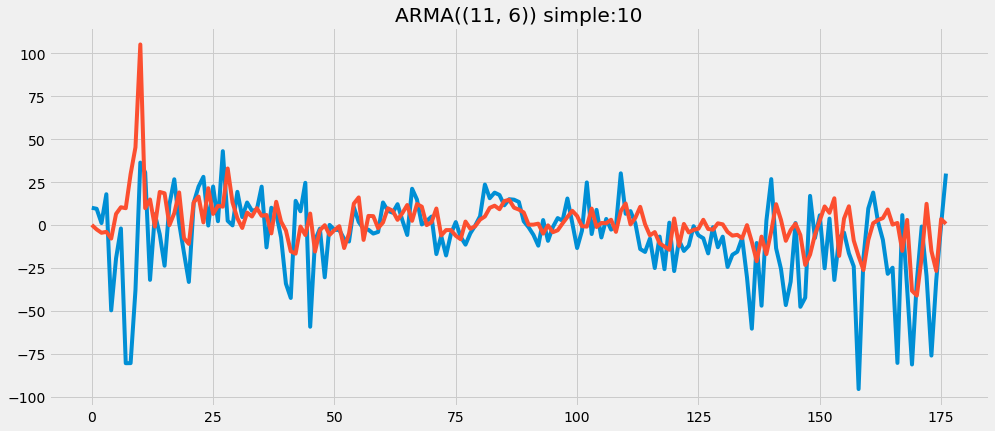

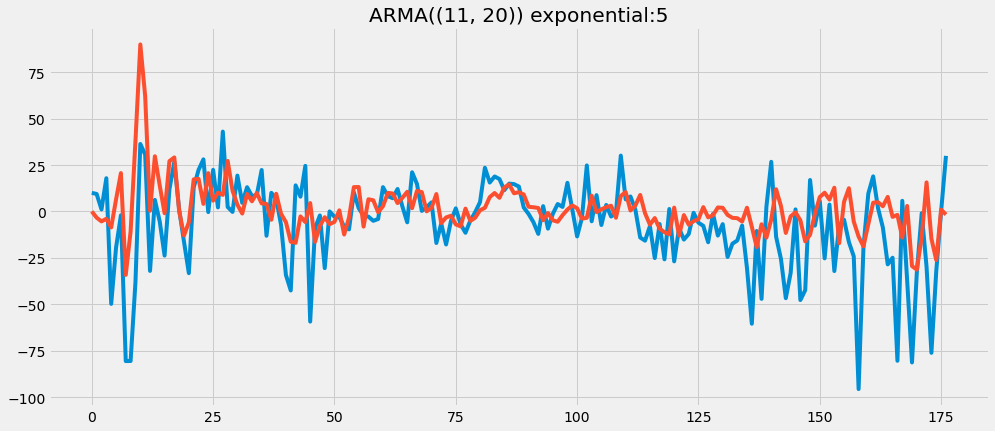

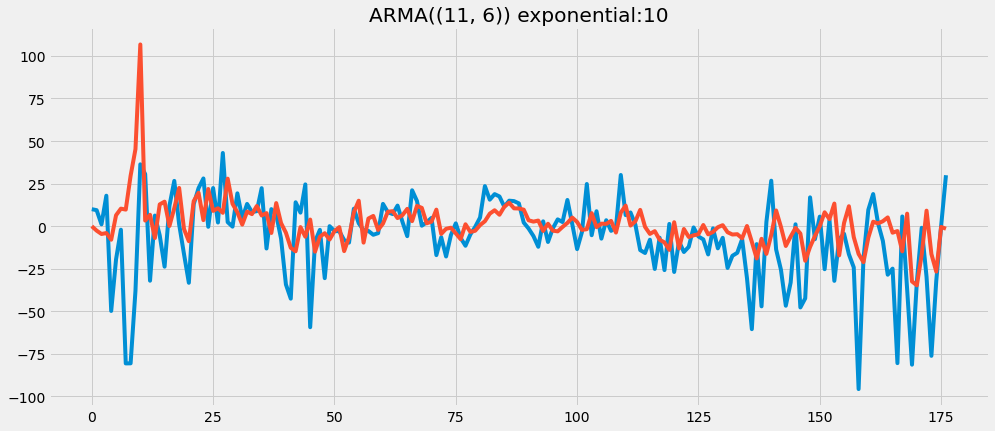

In [37]:
for name, y_pred in zip(models_metrics_1.name, predictions_model_1):
    show_prediction(y, y_pred, name)

In [38]:
models_metrics_1.to_excel('result/table_2_2.xls')

## Обчислення коефіцієнтів 

In [39]:
models_metrics_2 = pd.DataFrame(columns=['name', 'r_squared', 'sum_squared_resid', 'aic','durbin_watson','params_ar', 'params_ma','params_intercept'])
predictions_model_2 = []

q = 11
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_simple[0], mv5_simple[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

q = 6
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_simple[0], mv10_simple[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='simple', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

q = 20
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv5_exp[0], mv5_exp[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=5, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

q = 6
pred, params_ar, params_ma, intercept = ARMA(p, q, y - mv10_exp[0], mv10_exp[0])
metrics = claculate_metrics_model(y, pred, p, q, weight='exponential', window=10, params_ar=params_ar, params_ma=params_ma, intercept=intercept)
models_metrics_2 = models_metrics_2.append(metrics, ignore_index=True)
predictions_model_2.append(pred)

## зообразимо отримані метрики готових моделей

In [40]:
models_metrics_2

,name,r_squared,sum_squared_resid,aic,durbin_watson,params_ar,params_ma,params_intercept
0,"ARMA((11, 11)) simple:5",0.121642,71435.3,1106.07,1.88162,"[[0.03699527882490459], [-0.18899083087348056]...","[[1.1665813898306134], [-0.18844381099405497],...",[-0.30297726000667224]
1,"ARMA((11, 6)) simple:10",0.075913,84331.4,1125.45,1.78919,"[[0.18866755132264032], [-0.048288064821058505...","[[1.1505614578453738], [-0.6460376342146935], ...",[-0.7554047727978852]
2,"ARMA((11, 20)) exponential:5",0.120725,63346.3,1102.8,1.82795,"[[-0.04895240023166991], [-0.17593400222918576...","[[0.87036203860074], [-0.020190356110768297], ...",[-0.6114992977144831]
3,"ARMA((11, 6)) exponential:10",0.0703836,83184.9,1123.02,1.8381,"[[0.10870324400757789], [-0.09558744885469835]...","[[1.1015452627419922], [-0.5810669358165418], ...",[-1.0317496383427467]


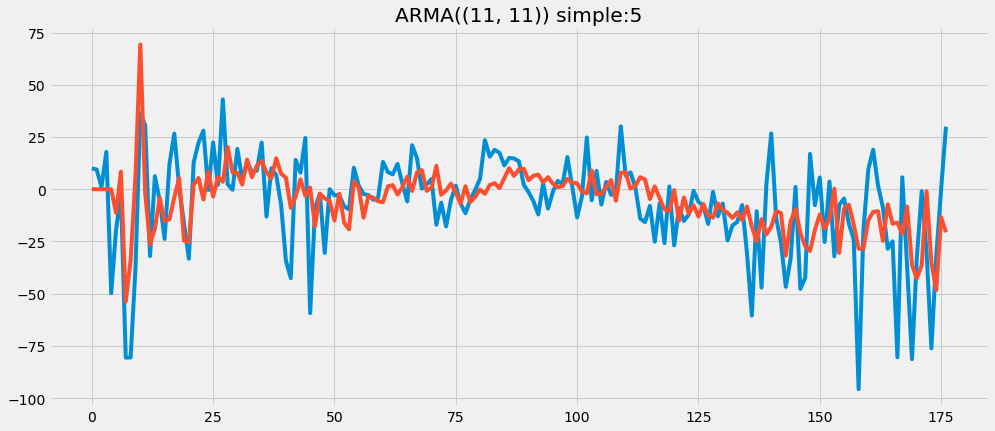

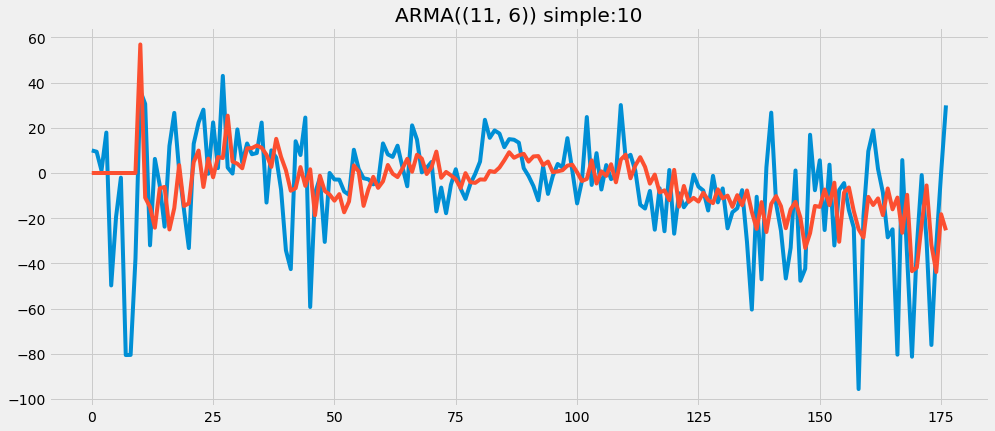

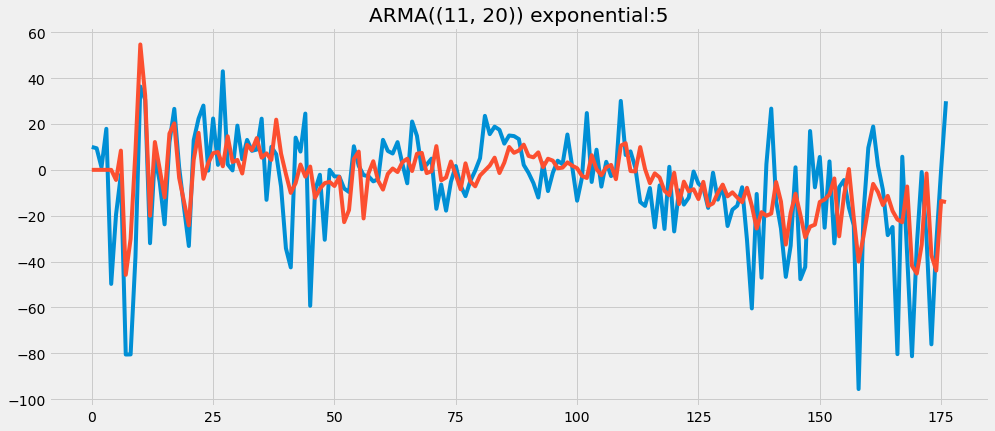

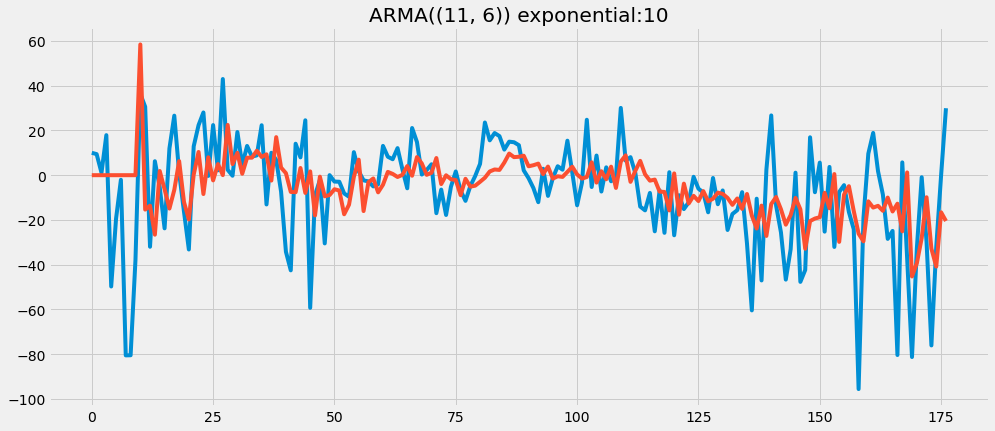

In [41]:
for name, y_pred in zip(models_metrics_2.name, predictions_model_2):
    show_prediction(y, y_pred, name)

In [42]:
models_metrics_2.to_excel('result/table_3_2.xls')